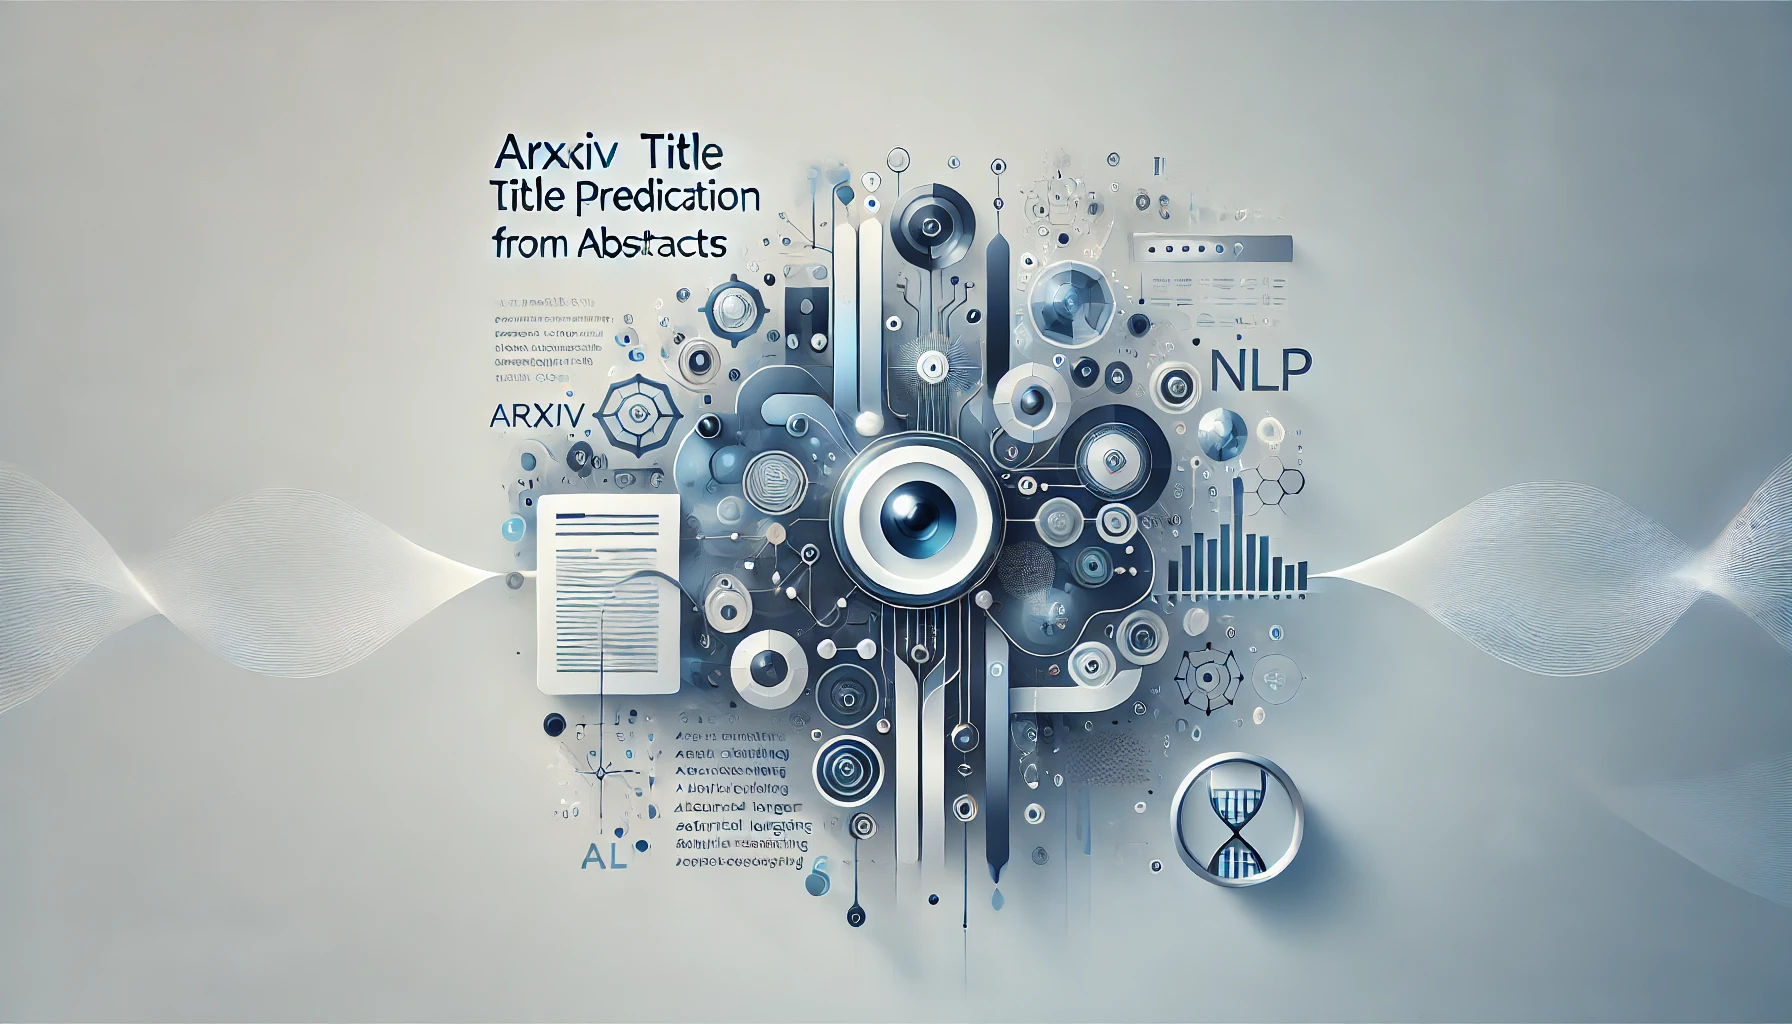

# Problem Statement

With the exponential growth of academic publications, particularly in online repositories like ArXiv, researchers often face challenges in quickly summarizing or titling their work. Crafting an appropriate, concise, and informative title is essential for ensuring that research papers are discoverable and attract attention. However, the manual process of title creation can be time-consuming and subjective. This project aims to automate the generation of titles from abstracts using machine learning models, specifically leveraging natural language processing (NLP) techniques.

# Objectives

1. **Automate Title Generation**: Develop a model capable of generating accurate and relevant titles based on research paper abstracts.
2. **Evaluate Model Performance**: Use metrics like ROUGE, BLEU, and accuracy to evaluate the quality and relevance of the generated titles against true titles.
3. **Improve Research Discoverability**: By providing an automated system for title generation, enhance the efficiency of the publication process and potentially increase the visibility of research papers.
4. **Explore NLP Techniques**: Implement and fine-tune state-of-the-art NLP models, such as Seq2Seq architectures, Transformers (e.g., BART, T5), to determine the most effective approach for this task.

# Impact

1. **Efficiency in Research Publication**: Automating title generation can save researchers time, allowing them to focus more on content creation and less on administrative tasks.
2. **Enhanced Research Discovery**: With more consistently titled papers, search engines and recommendation systems can better index and retrieve relevant research, improving accessibility and impact.
3. **Advancement in NLP Applications**: This project contributes to the field of NLP by applying advanced models to a real-world problem, providing insights into their practical applications and limitations.

# Procedures

1. **Data Collection**:
   - Obtain a dataset of abstracts and corresponding titles from ArXiv or a similar academic repository.
   - Clean and preprocess the data to ensure consistency (e.g., lowercasing, removing special characters).

2. **Data Preprocessing**:
   - Tokenize the text data and prepare it for model input.
   - Split the data into training, validation, and test sets.

3. **Model Selection and Training**:
   - Choose appropriate NLP models, such as Seq2Seq, Transformers (e.g., BART, T5), and fine-tune them on the training data.
   - Use cross-entropy loss and optimize the model to minimize this loss function during training.

4. **Evaluation**:
   - Evaluate the model’s performance using metrics like ROUGE, BLEU, and accuracy on the validation and test sets.
   - Analyze cases of high and low performance to understand model strengths and weaknesses.

5. **Error Analysis**:
   - Identify common failure modes and explore why the model underperforms in certain cases (e.g., abstracts that are too complex or titles that require domain-specific knowledge).
   - Consider adjustments to the model architecture or training process based on these insights.

6. **Model Refinement**:
   - Fine-tune the model further based on error analysis.
   - Test different architectures or hyperparameters to optimize performance.

7. **Deployment (if applicable)**:
   - If the project scope includes deployment, create a user interface or API that allows users to input abstracts and receive title suggestions.

**In this notebook, we use [BART](https://arxiv.org/abs/1910.13461) Transformer model to perform title generation from abstracts. BART is a sequence-to-sequence model where both the input and targets are text sequences. BART is commonly used for text summarization. In our case, we would want to summarize titles from abstracts.**

# Importing Necessary Libraries

In [ ]:
%%time

!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip uninstall -q tqdm -y > /dev/null
!pip install -q tqdm==4.48.1 > /dev/null
!pip uninstall -q torch -y > /dev/null
!pip install -q torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
!pip install -q -U tokenizers==0.7.0 > /dev/null
!pip install -q -U transformers==3.0.2 > /dev/null
!pip install -q -U simpletransformers==0.46.0 > /dev/null

     |████████████████████████████████| 2.1 MB 11.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.1
    Uninstalling pip-20.2.1:
      Successfully uninstalled pip-20.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you have torch 1.6.0+cu101 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you have torch 1.6.0+cu101 which is incompatible.
allennlp 1.0.0 requires transformers<2.12,>=2.9, but you have transformers 3.0.2 which is incompatible.
CPU times: user 1.76 s, sys: 431 ms, total: 2.19 s
Wall time: 1min 47s


This block of code is setting up your environment by installing and upgrading necessary Python packages. Here's a breakdown of what each part does:

***Breakdown***

1. **`%%time`**:
   - This is a Jupyter notebook magic command that measures the time taken to execute the entire cell. It will display how long it takes to install all the packages.

2. **`!/opt/conda/bin/python3.7 -m pip install --upgrade pip`**:
   - This upgrades `pip`, the Python package installer, to the latest version using Python 3.7. The `!` at the beginning is used to execute shell commands from within a Jupyter notebook.

3. **`!pip uninstall -q tqdm -y > /dev/null`**:
   - This command uninstalls the `tqdm` package silently (no output due to `-q` and `> /dev/null`).
   - The `-y` flag automatically confirms the uninstallation without prompting the user.

4. **`!pip install -q tqdm==4.48.1 > /dev/null`**:
   - Installs a specific version of the `tqdm` package (version 4.48.1) silently.

5. **`!pip uninstall -q torch -y > /dev/null`**:
   - Uninstalls the `torch` package (PyTorch library) silently.

6. **`!pip install -q torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null`**:
   - Installs a specific version of `torch` (PyTorch) with CUDA 10.1 support from the PyTorch official wheel repository silently.

7. **`!pip install -q -U tokenizers==0.7.0 > /dev/null`**:
   - Upgrades (`-U`) and installs a specific version of the `tokenizers` package (version 0.7.0) silently.

8. **`!pip install -q -U transformers==3.0.2 > /dev/null`**:
   - Upgrades and installs the `transformers` package (version 3.0.2), which provides state-of-the-art models like BERT, GPT, etc.

9. **`!pip install -q -U simpletransformers==0.46.0 > /dev/null`**:
   - Upgrades and installs `simpletransformers` (version 0.46.0), which is a wrapper for the `transformers` library, simplifying the process of fine-tuning models.

In [ ]:
import numpy as np
import pandas as pd
#import gdown
import os, json, gc, re, random
from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Hear `import logging` and `logging.basicConfig(level=logging.INFO)` represents:
- The `logging` module is used for tracking events that happen when software runs. Setting the logging level to `INFO` allows you to capture and display information messages.
- The `transformers_logger` is specifically set to `WARNING` to suppress less severe messages from the `transformers` library, allowing you to focus on more critical messages.

In [ ]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


('1.6.0+cu101', '3.0.2', '0.8.1.rc1')

1. **`import torch, transformers, tokenizers`**:
   - **`torch`**: This is the PyTorch library, which is used for deep learning. It provides tools for building and training neural networks.
   - **`transformers`**: This library, developed by Hugging Face, provides implementations of state-of-the-art transformer models like BERT, GPT, T5, etc.
   - **`tokenizers`**: This is a fast tokenizer library, also developed by Hugging Face, optimized for handling large volumes of text data.

2. **`torch.__version__, transformers.__version__, tokenizers.__version__`**:
   - This line retrieves and prints the version numbers of the installed `torch`, `transformers`, and `tokenizers` libraries. The `__version__` attribute of each library is accessed to get the version string.

# Load and Read JSON Data

In [ ]:
#If you are doing from google colab
'''
url = '1NUgTzxmLeT3easvuI6xWc2Dw-ixhsQiE'
out = 'ArXiv Dataset'
gdown.download_folder(id=url, output=out, quiet=False)
data_file = '/content/ArXiv Dataset/arxiv-metadata-oai-snapshot.json'
'''

"\nurl = '1NUgTzxmLeT3easvuI6xWc2Dw-ixhsQiE'\nout = 'ArXiv Dataset'\ngdown.download_folder(id=url, output=out, quiet=False)\ndata_file = '/content/ArXiv Dataset/arxiv-metadata-oai-snapshot.json'\n"

In [ ]:
data_file = '../input/arxiv/arxiv-metadata-oai-snapshot.json'

In [ ]:
def get_metadata():
    """Using `yield` to load the JSON file in a loop to prevent Python memory issues if JSON is loaded directly"""

    with open(data_file, 'r') as f:
        for line in f:
            yield line

Let's print a sample paper metadata

In [ ]:
metadata = get_metadata()

for paper in metadata:
    for k, v in json.loads(paper).items():
        print(f'{k}: {v} \n')
    break

id: 0704.0001 

submitter: Pavel Nadolsky 

authors: C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan 

title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies 

comments: 37 pages, 15 figures; published version 

journal-ref: Phys.Rev.D76:013009,2007 

doi: 10.1103/PhysRevD.76.013009 

report-no: ANL-HEP-PR-07-12 

categories: hep-ph 

license: None 

abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
m

## Category Mapping

In [ ]:
category_map = {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}

# Abstract Summarization

## Title Prediction from Abstract using **BART**

For this task, let's choose all paper categories published in the last decade

In [ ]:
titles = []
abstracts = []

# Consider all categories in the `category_map` to be used during training and prediction
paper_categories = np.array(list(category_map.keys())).flatten()

# # Consider specific paper categories to be used during training and prediction
# paper_categories = ["cs.AI", # Artificial Intelligence
#                     "cs.CV", # Computer Vision and Pattern Recognition
#                     "cs.LG"] # Machine Learning

Now the titles and abstracts have to be extracted from the metadata for papers that meet specific criteria such as belonging to certain categories and being published between 2010 and 2021.

In [ ]:
metadata = get_metadata()

for paper in tqdm(metadata):
    paper_dict = json.loads(paper)
    category = paper_dict.get('categories')

    try:
        year = int(paper_dict.get('journal-ref')[-4:])

        if category in paper_categories and 2010<year<2021:
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract').replace("\n",""))

    except:
        pass

2560035it [01:21, 31266.04it/s]


In [ ]:
len(titles), len(abstracts)

(21641, 21641)

## Data Pre-processing

In [ ]:
papers = pd.DataFrame({'title': titles,
                       'abstract': abstracts})

In [ ]:
papers = papers[['abstract', 'title']]
papers.head()

,abstract,title
0,We present in this article a detailed quanti...,A unified analysis of the reactor neutrino pro...
1,The aim of the KArlsruhe TRItium Neutrino ex...,The KATRIN sensitivity to the neutrino mass an...
2,"In this letter, we propose three different s...","Penguin-mediated B_(d,s)->VV decays and the Bs..."
3,We find non-supersymmetric metastable vacua ...,Non Supersymmetric Metastable Vacua in N=2 SYM...
4,We show how to test whether a graph with n v...,Recognizing Partial Cubes in Quadratic Time


In [ ]:
papers.columns = ['input_text', 'target_text']
papers = papers.dropna()
papers.head()

,input_text,target_text
0,We present in this article a detailed quanti...,A unified analysis of the reactor neutrino pro...
1,The aim of the KArlsruhe TRItium Neutrino ex...,The KATRIN sensitivity to the neutrino mass an...
2,"In this letter, we propose three different s...","Penguin-mediated B_(d,s)->VV decays and the Bs..."
3,We find non-supersymmetric metastable vacua ...,Non Supersymmetric Metastable Vacua in N=2 SYM...
4,We show how to test whether a graph with n v...,Recognizing Partial Cubes in Quadratic Time


In [ ]:
del titles, abstracts
papers.head()

,input_text,target_text
0,We present in this article a detailed quanti...,A unified analysis of the reactor neutrino pro...
1,The aim of the KArlsruhe TRItium Neutrino ex...,The KATRIN sensitivity to the neutrino mass an...
2,"In this letter, we propose three different s...","Penguin-mediated B_(d,s)->VV decays and the Bs..."
3,We find non-supersymmetric metastable vacua ...,Non Supersymmetric Metastable Vacua in N=2 SYM...
4,We show how to test whether a graph with n v...,Recognizing Partial Cubes in Quadratic Time


In [ ]:
papers.shape

(21641, 2)

## Model Training & Evaluation

In [ ]:
%%time

from simpletransformers.seq2seq import Seq2SeqModel

eval_df = papers.sample(frac=0.1, random_state=42)
train_df = papers.drop(eval_df.index)

CPU times: user 52.6 ms, sys: 5.05 ms, total: 57.7 ms
Wall time: 73 ms


Now we are setting up the data for training and evaluation using the `simpletransformers` library's `Seq2SeqModel`.

1. **`from simpletransformers.seq2seq import Seq2SeqModel`**:
   - This imports the `Seq2SeqModel` class from the `simpletransformers` library, which is used for sequence-to-sequence tasks (e.g., translating text, summarizing text, or generating text from prompts).
   - The `Seq2SeqModel` class simplifies the process of training, evaluating, and using sequence-to-sequence models.

2. **`eval_df = papers.sample(frac=0.1, random_state=42)`**:
   - **`papers.sample(...)`**: Randomly samples a fraction of the rows from the `papers` DataFrame.
   - **`frac=0.1`**: Specifies that 10% of the rows in `papers` should be sampled for the evaluation dataset.
   - **`random_state=42`**: Ensures that the sampling is reproducible by setting a seed for the random number generator. This means that every time you run the code, the same 10% of the data will be selected.
   - The resulting DataFrame, `eval_df`, contains the evaluation data that will be used to assess the model's performance after training.

3. **`train_df = papers.drop(eval_df.index)`**:
   - **`papers.drop(eval_df.index)`**: Removes the rows in `papers` that are included in `eval_df`, effectively leaving the remaining 90% of the data.
   - The resulting DataFrame, `train_df`, contains the training data that will be used to train the model.

In [ ]:
model_args = {"reprocess_input_data": True,
              "overwrite_output_dir": True,
              "save_model_every_epoch": False,
              "save_eval_checkpoints": False,
              "max_seq_length": 512,
              "train_batch_size": 6,
              "num_train_epochs": 3}

### Creating BART-based Model

In [ ]:
%%time

# Create a Bart-base model
model = Seq2SeqModel(encoder_decoder_type="bart",
                     encoder_decoder_name="facebook/bart-base",
                     args=model_args)


CPU times: user 17.8 s, sys: 1.95 s, total: 19.8 s
Wall time: 34.6 s


Here we are creating a BART (Bidirectional and Auto-Regressive Transformers) model using the `simpletransformers` library.

**Purpose of `Seq2SeqModel(...)`**:
   - This initializes a sequence-to-sequence model using the `simpletransformers.seq2seq.Seq2SeqModel` class.
   - **`encoder_decoder_type="bart"`**: Specifies that you are using the BART model architecture for both the encoder and decoder.
   - **`encoder_decoder_name="facebook/bart-base"`**: Specifies the name of the pre-trained model to use. `"facebook/bart-base"` refers to the BART-base model developed by Facebook, which is a smaller version of BART, pre-trained on a large corpus of text data.
   - **`args=model_args`**: Passes the `model_args` dictionary you defined earlier, which contains various configurations like the number of training epochs, batch size, and more.

### Training the Model

In [ ]:
%%time

# Train the model
model.train_model(train_df)



CPU times: user 2h 9min 31s, sys: 1min 42s, total: 2h 11min 14s
Wall time: 1h 40min 35s


### Model Evaluation

In [ ]:
%%time

# Evaluate the model
result = model.eval_model(eval_df)
print(result)


{'eval_loss': 2.2128872215967776}
CPU times: user 1min 59s, sys: 3.18 s, total: 2min 2s
Wall time: 1min 19s


## Prediction

In [ ]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
rogue = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [ ]:
abstracts = []
true_titles = []
predicted_titles = []
rouge_scores_list = []
bleu_scores = []
accuracy_list = []

### Predictions Printed as .txt File

In [ ]:
with open('random_sample_predictions_with_metrics.txt', 'w') as f:

    # Loop through the evaluation dataset 250 times randomly
    for _ in range(250):
        random_idx = random.randint(0, len(eval_df)-1)

        # Retrieve abstract and true title
        abstract = eval_df.iloc[random_idx]['input_text']
        true_title = eval_df.iloc[random_idx]['target_text']

        # Predict the title using the trained model
        predicted_title = model.predict([abstract])[0]

        # Calculate ROUGE score
        rouge_score = rogue.score(true_title, predicted_title)['rougeL'].fmeasure
        rouge_scores_list.append(rouge_score)

        # Calculate BLEU score
        bleu_score = sentence_bleu([true_title.split()], predicted_title.split())
        bleu_scores.append(bleu_score)

        # Calculate Exact Match Accuracy
        accuracy = 1 if predicted_title == true_title else 0
        accuracy_list.append(accuracy)

        # Store the abstract, true title, and predicted title
        abstracts.append(abstract)
        true_titles.append(true_title)
        predicted_titles.append(predicted_title)

        # Write each result to the text file
        f.write(f'True Title: {true_title}\n')
        f.write(f'Predicted Title: {predicted_title}\n')
        f.write(f'Abstract: {abstract}\n\n\n')

### Predictions DataFrame

In [ ]:
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Abstract': abstracts,
    'True Title': true_titles,
    'Predicted Title': predicted_titles,
    'ROUGE Score': rouge_scores_list,
    'BLEU Score': bleu_scores,
    'Accuracy': accuracy_list
})

# Display the first few rows of the DataFrame to verify
results_df.head()

,Abstract,True Title,Predicted Title,ROUGE Score,BLEU Score,Accuracy
0,"We introduce Sieve-SDP, a simple facial redu...",Sieve-SDP: a simple facial reduction algorithm...,Sieve-SDP: A Simple Facial Reduction Algorithm...,0.800000,0.463078,0
1,A fundamental task for propositional logic i...,Transition Systems for Model Generators - A Un...,Satisfiability solvers for propositional logic,0.153846,0.300484,0
2,We continue the investigation of two-loop st...,Two-loop AdS_5 x S^5 superstring: testing asym...,Two-loop corrections to the energy of folded s...,0.240000,0.378487,0
3,"Social Media involve many shared items, such...",Privacy Policy Negotiation in Social Media,A Heuristic for a Better Privacy-Aware Social ...,0.352941,0.427287,0
4,We review some topological effects on the co...,Topological effects on string vacua,Topological effects on the construction of str...,0.714286,0.392815,0


In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('random_sample_predictions_with_metrics.csv', index=False)

## Visualizing the Model's Performance

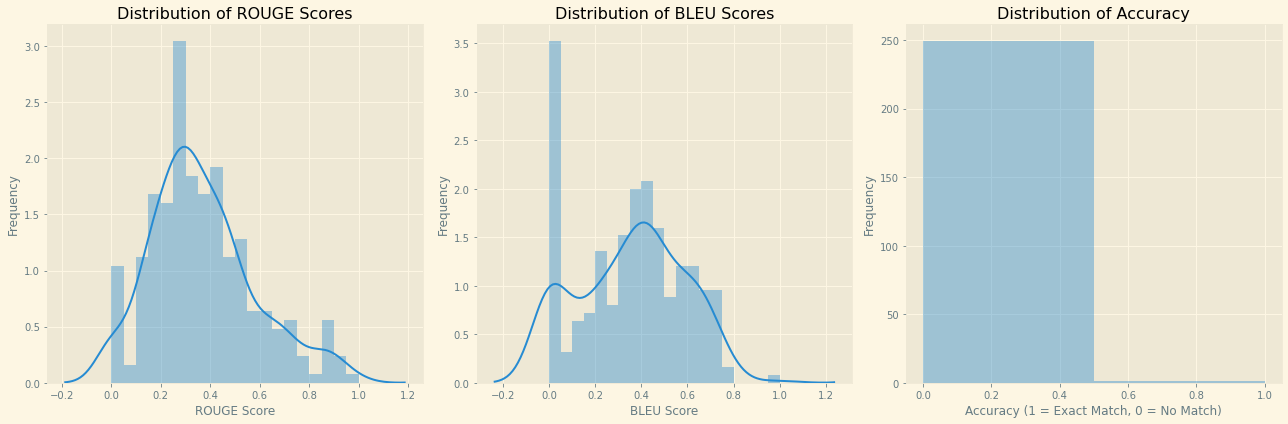

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.style.use('Solarize_Light2')

# Plot the distribution of ROUGE scores
sns.distplot(rouge_scores_list, bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of ROUGE Scores')
axes[0].set_xlabel('ROUGE Score')
axes[0].set_ylabel('Frequency')

# Plot the distribution of BLEU scores
sns.distplot(bleu_scores, bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of BLEU Scores')
axes[1].set_xlabel('BLEU Score')
axes[1].set_ylabel('Frequency')

# Plot the distribution of Accuracy
sns.distplot(accuracy_list, bins=2, kde=False, ax=axes[2])
axes[2].set_title('Distribution of Accuracy')
axes[2].set_xlabel('Accuracy (1 = Exact Match, 0 = No Match)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The plot consists of three subplots, each showing the distribution of different evaluation metrics for your model's predictions. Here's an explanation of each subplot:

1. ***Distribution of ROUGE Scores (Left Plot)***
   - **X-Axis**: Represents the ROUGE scores, specifically the ROUGE-L F1 scores, which measure the overlap between the predicted titles and the true titles, focusing on the longest common subsequence.
   - **Y-Axis**: Represents the frequency of each ROUGE score across your evaluation dataset.
   - **Interpretation**:
     - The ROUGE scores are distributed mostly between 0.0 and 0.7, with a peak around 0.3-0.4. This suggests that most of the predicted titles have a moderate level of overlap with the true titles, though there are variations, with some predictions performing better (higher ROUGE scores) and others worse (lower ROUGE scores).

2. ***Distribution of BLEU Scores (Middle Plot)***
   - **X-Axis**: Represents the BLEU scores, which measure how many n-grams in the predicted titles match those in the true titles. BLEU is a common metric for evaluating machine translation and text generation.
   - **Y-Axis**: Represents the frequency of each BLEU score across your evaluation dataset.
   - **Interpretation**:
     - The BLEU scores show a bimodal distribution with two peaks: one around 0 (indicating very poor matches) and another around 0.3-0.4 (indicating moderate matches). This suggests that there are a significant number of cases where the model's predictions are either very close or quite far from the true titles.

3. ***Distribution of Accuracy (Right Plot)***
   - **X-Axis**: Represents the accuracy, where 1 indicates an exact match between the predicted and true titles, and 0 indicates no match.
   - **Y-Axis**: Represents the frequency of each accuracy value across your evaluation dataset.
   - **Interpretation**:
     - The accuracy plot shows that the vast majority of predictions are not exact matches, as indicated by the large spike at 0. This is common in text generation tasks, where generating a title that exactly matches the true title is quite challenging. The bar at 1, representing exact matches, is much smaller, indicating that only a few titles were predicted exactly.

***General Observations***
- **ROUGE and BLEU Scores**: Both metrics suggest that while your model is able to generate somewhat relevant titles, there is room for improvement, particularly in generating more precise and accurate titles.
- **Accuracy**: The low accuracy score is expected in text generation tasks, especially when the model is not perfectly tuned or the task is inherently difficult.
- The model performs poorly (e.g., BLEU scores near 0) and in order to understand where it struggles the most we may look into specific examples.

This analysis helps you understand the effectiveness of your model and where you might focus your efforts to improve its performance.

### Average ROUGE Score

In [ ]:
rouge_scores = [rogue.score(true_title, predicted_title)['rougeL'].fmeasure for true_title, predicted_title in zip(true_titles, predicted_titles)]
average_rouge = sum(rouge_scores) / len(rouge_scores)
print("Average ROUGE Score:", average_rouge)

Average ROUGE Score: 0.3694946407659669


### Average BLEU Score

In [ ]:
# Calculate BLEU for each pair and average them
bleu_scores = [sentence_bleu([true_title.split()], predicted_title.split()) for true_title, predicted_title in zip(true_titles, predicted_titles)]
average_bleu = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu)

Average BLEU Score: 0.3540684884274187


### Average Exact-Match Accuracy

In [ ]:
exact_matches = sum([1 for true_title, predicted_title in zip(true_titles, predicted_titles) if true_title == predicted_title])
accuracy = exact_matches / len(true_titles)
print("Exact Match Accuracy:", accuracy)

Exact Match Accuracy: 0.004


The outputs are summary statistics that evaluate the performance of your model in generating titles from abstracts. Here’s what each of these metrics means:

***1. Average ROUGE Score: 0.369***
   - **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** is a metric used to evaluate the quality of summaries or generated text, such as titles in your case.
   - **ROUGE-L** specifically measures the longest common subsequence (LCS) between the predicted and the true title. It captures both precision and recall by considering the sequence of words in the text.
   - **Average ROUGE Score of 0.369**: This indicates that, on average, the predicted titles have a moderate level of overlap with the true titles. A score of 0.369 suggests that while your model captures some important aspects of the true titles, there’s still significant room for improvement. The closer the score is to 1, the better the model is at generating titles that closely resemble the true titles.

***2. Average BLEU Score: 0.354***
   - **BLEU (Bilingual Evaluation Understudy)** is another widely used metric for evaluating the quality of machine-generated text, commonly used in tasks like machine translation and text generation.
   - BLEU measures the overlap of n-grams (sequences of n words) between the generated text and the reference text (true title). It focuses more on precision (how much of the generated title matches the true title).
   - **Average BLEU Score of 0.354**: This score suggests that, on average, about 35.4% of the n-grams in the predicted titles match those in the true titles. Like ROUGE, this is a moderate score, indicating that while your model is somewhat successful in generating relevant phrases, it often misses or incorrectly generates some key n-grams.

***3. Exact Match Accuracy: 0.004***
   - **Exact Match Accuracy** measures the percentage of predicted titles that exactly match the true titles.
   - **Exact Match Accuracy of 0.004 (or 0.4%)**: This extremely low score indicates that only 0.4% of the predicted titles are exactly the same as the true titles. This is not uncommon in text generation tasks, especially with abstract and title generation, where exact matches are difficult to achieve due to the variability in how titles can be phrased.
   - This low score highlights that while the model may generate titles that capture some elements of the true title (as reflected by the ROUGE and BLEU scores), it rarely gets the entire title exactly correct.

***Overall Interpretation***
- **Moderate Performance**: The ROUGE and BLEU scores indicate that the model is moderately successful in generating titles that share some similarities with the true titles. It can capture some relevant words and phrases, but often falls short of producing highly accurate or fully relevant titles.
- **Low Exact Match**: The very low exact match accuracy suggests that while the model occasionally gets parts of the title correct, it rarely produces a title that is an exact match to the reference. This is expected given the flexibility and variation in how titles can be written.
- **Improvement Opportunities**: There is significant room for improvement, especially if the goal is to produce titles that are more accurate or closely aligned with the true titles. This could involve further model fine-tuning, better preprocessing of data, or experimenting with different model architectures.

***Next Steps***
- **Error Analysis**: Investigate cases where the model fails (e.g., very low ROUGE/BLEU scores) to understand common mistakes. This might involve looking at specific examples of abstracts and the generated titles.
- **Model Refinement**: Consider experimenting with different model architectures, adding more data, or using techniques like beam search or reinforcement learning to improve the quality of the generated titles.
- **Domain-Specific Training**: If the model is struggling with specific types of abstracts, consider using domain-specific training data to improve its performance in those areas.

These metrics provide a quantitative assessment of how well your model is performing and can guide you in making further improvements.

# Error Analysis

In [ ]:
import csv

with open('error_analysis.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Abstract", "True Title", "Predicted Title", "ROUGE Score", "BLEU Score"])

    for abstract, true_title, predicted_title, rouge, bleu in zip(eval_df['input_text'], true_titles, predicted_titles, rouge_scores, bleu_scores):
        writer.writerow([abstract, true_title, predicted_title, rouge, bleu])

In [ ]:
file_path = '/kaggle/working/error_analysis.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Abstract,True Title,Predicted Title,ROUGE Score,BLEU Score
0,Classical secular theory can be a powerful t...,Sieve-SDP: a simple facial reduction algorithm...,Sieve-SDP: A Simple Facial Reduction Algorithm...,0.800000,0.463078
1,We prove sharp $L^3$ bounds for a variable c...,Transition Systems for Model Generators - A Un...,Satisfiability solvers for propositional logic,0.153846,0.300484
2,Publish/subscribe (pub/sub) is an attractive...,Two-loop AdS_5 x S^5 superstring: testing asym...,Two-loop corrections to the energy of folded s...,0.240000,0.378487
3,We continue the investigation of two-loop st...,Privacy Policy Negotiation in Social Media,A Heuristic for a Better Privacy-Aware Social ...,0.352941,0.427287
4,Temporal coding is one approach to represent...,Topological effects on string vacua,Topological effects on the construction of str...,0.714286,0.392815


## Distributions of ROUGE and BLEU Scores

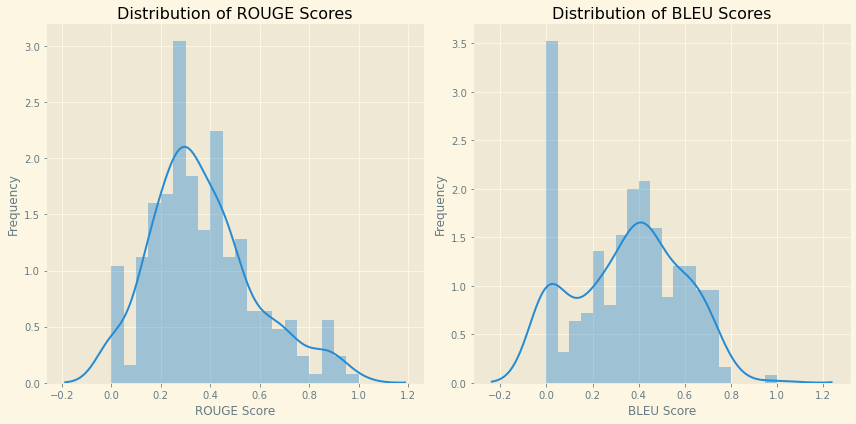

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plt.style.use('Solarize_Light2')

# Plot the distribution of ROUGE scores
sns.distplot(df['ROUGE Score'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of ROUGE Scores')
axes[0].set_xlabel('ROUGE Score')
axes[0].set_ylabel('Frequency')

# Plot the distribution of BLEU scores
sns.distplot(df['BLEU Score'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of BLEU Scores')
axes[1].set_xlabel('BLEU Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The image shows two side-by-side histograms that display the distribution of ROUGE and BLEU scores. These scores are commonly used to evaluate the quality of text generation tasks, such as generating titles from abstracts.

1. ***Distribution of ROUGE Scores (Left Plot)***
   - **X-Axis**: Represents the ROUGE scores, specifically the ROUGE-L F1 scores, which measure the overlap between the predicted titles and the true titles. ROUGE-L focuses on the longest common subsequence between the two texts.
   - **Y-Axis**: Represents the frequency of these scores across the evaluation dataset.
   - **Interpretation**:
     - The ROUGE scores are primarily distributed between 0.0 and 0.7, with a noticeable peak around 0.3-0.4. This indicates that most of the predicted titles have a moderate level of similarity to the true titles, although there is some variation.
     - The plot shows a small number of cases with higher scores (closer to 1.0) and lower scores (close to 0.0), suggesting that the model occasionally produces highly accurate or highly inaccurate predictions.

2. ***Distribution of BLEU Scores (Right Plot)***
   - **X-Axis**: Represents the BLEU scores, which measure how many n-grams (subsequences of words) in the predicted titles match those in the true titles. BLEU is widely used in machine translation and text generation evaluation.
   - **Y-Axis**: Represents the frequency of BLEU scores across the dataset.
   - **Interpretation**:
     - The BLEU score distribution is bimodal, with one peak at 0.0 and another around 0.3-0.4. The peak at 0.0 suggests that there are a significant number of cases where the model’s predictions have very little n-gram overlap with the true titles.
     - The second peak at 0.3-0.4 indicates that a substantial number of predictions have moderate overlap with the true titles. The tail of the distribution extends to higher scores, showing that in some cases, the model's predictions are quite good (BLEU scores closer to 1.0).

***General Observations***
- **ROUGE Scores**: The model’s performance, as measured by ROUGE, tends to hover around moderate similarity levels. This suggests that while the model is capturing some relevant information, there is room for improvement in terms of producing more precise and accurate titles.
- **BLEU Scores**: The BLEU score distribution indicates that the model struggles with some predictions (those with scores close to 0.0), but also manages to produce reasonable predictions in other cases. The bimodal distribution might suggest variability in the complexity or nature of the titles being generated.

***Potential Next Steps***
- **Error Analysis**: Investigate the cases where the model achieves very low BLEU or ROUGE scores to understand why the predictions are poor. This could involve looking at the specific abstracts and titles to see if there are common characteristics (e.g., length, complexity, specific terminology) that the model struggles with.
- **Model Fine-Tuning**: Consider fine-tuning the model further or experimenting with different model architectures or training datasets to improve the overlap between predicted and true titles.
- **Data Augmentation**: You might consider augmenting your training data or incorporating more examples to help the model better learn to generate accurate titles.

This visualization provides a good overview of your model’s performance and highlights areas where improvements can be made.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ROUGE Score,250.0,0.369495,0.211566,0.0,0.235294,0.333333,0.479048,1.0
BLEU Score,250.0,0.354068,0.228600,0.0,0.188580,0.387539,0.533051,1.0


In [ ]:
# Identify cases with low ROUGE scores
low_rouge = df[df['ROUGE Score'] < 0.2]
print(low_rouge.head())

# Identify cases with low BLEU scores
low_bleu = df[df['BLEU Score'] < 0.2]
print(low_bleu.head())

                                             Abstract  \
1     We prove sharp $L^3$ bounds for a variable c...   
6     We study the wave functions of light and hea...   
17    We study fermionic T-duality symmetries of i...   
28    We present a class of analytic solutions of ...   
30    We prove that an ultradistribution is rotati...   

                                           True Title  \
1   Transition Systems for Model Generators - A Un...   
6      ALICE HLT TPC Tracking of Pb-Pb Events on GPUs   
17  Controllability on relaxation-free subspaces: ...   
28  Image denoising by median filter in wavelet do...   
30  Black hole lightning due to particle accelerat...   

                                      Predicted Title  ROUGE Score  BLEU Score  
1      Satisfiability solvers for propositional logic     0.153846    0.300484  
6   GPU-based online tracker for the ALICE experiment     0.111111    0.461999  
17  Optimal control of transfer via intermediate d...     0.173913    0

## Relation between ROUGE and BLEU Scores

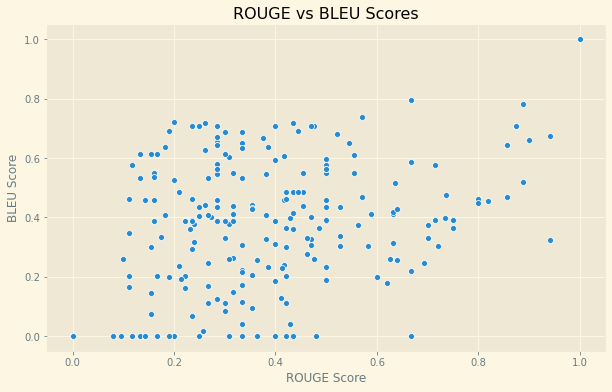

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ROUGE Score', y='BLEU Score')
plt.title('ROUGE vs BLEU Scores')
plt.show()

The plot is a scatter plot that compares the ROUGE scores to the BLEU scores for your model's predictions. Here’s a detailed explanation of what this plot tells you:

***Axes***
- **X-Axis (ROUGE Score):**
  - Represents the ROUGE scores, specifically ROUGE-L F1 scores. ROUGE-L measures the longest common subsequence overlap between the predicted title and the true title.
  - The scores range from 0.0 to 1.0, with higher scores indicating better overlap.

- **Y-Axis (BLEU Score):**
  - Represents the BLEU scores, which measure the n-gram overlap between the predicted title and the true title.
  - BLEU scores also range from 0.0 to 1.0, with higher scores indicating better n-gram precision.

***Interpretation of the Scatter Plot***
- **Each Point:**
  - Each point on the scatter plot represents a single instance (i.e., one predicted title) in your evaluation dataset, with its ROUGE score on the x-axis and its BLEU score on the y-axis.

- **Distribution:**
  - **Dense Region (Middle Left)**: A significant number of points are clustered around the middle of the ROUGE axis (around 0.2 to 0.5) and BLEU axis (around 0.2 to 0.6). This suggests that many predictions have moderate ROUGE and BLEU scores, indicating that they capture some elements of the true title but not all.
  - **Low Scores (Bottom Left)**: There are points near the bottom-left corner where both ROUGE and BLEU scores are low, indicating that for some predictions, the model's output had very little overlap with the true title in terms of both sequence and n-grams.
  - **High ROUGE with Low BLEU (Top Left)**: Some points have high ROUGE scores but relatively lower BLEU scores, which could indicate that while the predicted title captures the main idea or structure of the true title, it may miss out on precise word matches or sequence accuracy.
  - **High BLEU with Low ROUGE (Bottom Right)**: Conversely, you might find some points with higher BLEU scores but lower ROUGE scores, suggesting that while the predicted title has some accurate n-grams, it may not match the true title well in terms of overall structure or key content.

***Insights***
- **Correlation Between Metrics:**
  - The scatter plot shows a general trend where higher ROUGE scores are often associated with higher BLEU scores, but there’s variability, which is expected since these metrics measure different aspects of text similarity.
  - The lack of a strong linear correlation suggests that your model's performance might vary depending on the metric used, and improving one metric doesn't necessarily guarantee an improvement in the other.

- **Performance Analysis:**
  - If you observe many points in the lower-left quadrant, it indicates that there are cases where the model struggles to generate relevant titles. These cases could be analyzed further to identify common characteristics that the model finds difficult.
  - The presence of points in the upper-right quadrant (high ROUGE and BLEU scores) would indicate strong performance, with predictions that both capture the structure and the specific content of the true title accurately.

***Next Steps***
- **Focused Error Analysis:**
  - You might want to examine specific cases where the model has high ROUGE but low BLEU or vice versa. This could provide insights into whether the model is generally understanding the content but failing in specific details, or if there are issues with certain types of abstracts or titles.
  
- **Model Tuning:**
  - Depending on where most of your points lie, you could decide whether to focus on improving the precision of your n-grams (BLEU) or the overall structural and content similarity (ROUGE).

This scatter plot is useful for understanding how your model’s performance on ROUGE and BLEU metrics is related and can guide further improvements to the model.

## Outlier Detection for both the Scores

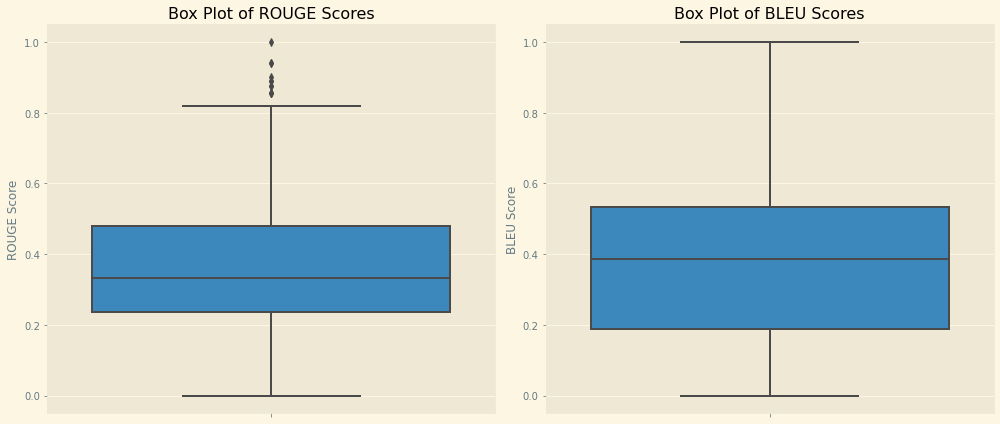

In [ ]:
plt.figure(figsize=(14, 6))

# Box plots for both metrics side by side
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='ROUGE Score')
plt.title('Box Plot of ROUGE Scores')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='BLEU Score')
plt.title('Box Plot of BLEU Scores')

plt.tight_layout()
plt.show()

The plot shows two side-by-side box plots: one for ROUGE scores and one for BLEU scores. Here's an explanation of what these box plots represent:

***1. Box Plot of ROUGE Scores (Left Plot)***
- **Y-Axis (ROUGE Score):**
  - Represents the ROUGE scores, specifically ROUGE-L F1 scores, which measure the overlap between the predicted titles and the true titles in terms of the longest common subsequence.
  - The scores range from 0.0 to 1.0, with higher scores indicating better overlap.

- **Box Plot Interpretation:**
  - **Box (Interquartile Range, IQR):**
    - The box shows the range between the first quartile (Q1, 25th percentile) and the third quartile (Q3, 75th percentile) of the data. This range is known as the interquartile range (IQR) and contains the middle 50% of the data points.
    - For ROUGE scores, the IQR appears to range approximately from 0.3 to 0.55, indicating that the central 50% of your data falls within this range.
  - **Median (Line inside the Box):**
    - The line inside the box represents the median (50th percentile) of the ROUGE scores. It appears to be around 0.45, indicating that half of your predictions have a ROUGE score below this value and half above.
  - **Whiskers:**
    - The whiskers extend from the box to the smallest and largest values within 1.5 times the IQR from the quartiles. The lower whisker extends down to 0, and the upper whisker extends up to about 0.8.
  - **Outliers (Points above the Upper Whisker):**
    - Points beyond the whiskers are considered outliers. These outliers in the plot represent predictions with unusually high ROUGE scores, indicating that for these specific cases, the predicted titles had a very high overlap with the true titles.

***2. Box Plot of BLEU Scores (Right Plot)***
- **Y-Axis (BLEU Score):**
  - Represents the BLEU scores, which measure the n-gram overlap between the predicted titles and the true titles. BLEU is a common metric for evaluating the quality of text generation, particularly in machine translation tasks.
  - The scores also range from 0.0 to 1.0, with higher scores indicating better n-gram precision.

- **Box Plot Interpretation:**
  - **Box (Interquartile Range, IQR):**
    - The IQR for BLEU scores appears to range from approximately 0.3 to 0.55, similar to the ROUGE scores, suggesting that the central 50% of your BLEU scores also fall within this range.
  - **Median (Line inside the Box):**
    - The median BLEU score is also around 0.4 to 0.45, meaning that the model's predictions generally have a moderate level of n-gram overlap with the true titles.
  - **Whiskers:**
    - The whiskers extend to the minimum score of 0.0 and the maximum score close to 1.0, indicating that there is a wider spread in the BLEU scores compared to ROUGE scores.
  - **No Outliers:**
    - Unlike the ROUGE plot, the BLEU plot does not show any significant outliers, suggesting a more consistent distribution of BLEU scores across the dataset.

***General Observations***
- **Central Tendency:** Both box plots show that the median values for ROUGE and BLEU are around the middle of their respective ranges, indicating that the model typically performs with moderate accuracy on these metrics.
- **Outliers in ROUGE:** The presence of outliers in the ROUGE scores suggests that while the majority of predictions are only moderately accurate, there are some cases where the model produces very accurate titles.
- **Whisker Length:** The longer whiskers on the BLEU plot suggest a wider spread of BLEU scores, meaning that there is more variability in how well the model captures n-gram overlap compared to how well it captures overall content overlap (as measured by ROUGE).

***Potential Next Steps***
- **Investigate Outliers:** It may be beneficial to look into the specific cases where ROUGE scores are unusually high to understand what characteristics of the abstracts or titles contribute to this success.
- **Focus on BLEU Variability:** Since BLEU scores show more variability, you might want to examine cases at the extremes to understand when and why the model performs very well or very poorly in terms of n-gram precision.

This analysis of the box plots gives you a better understanding of the central tendency and spread of your model's performance metrics, as well as potential areas for improvement. Let me know if you need any further assistance!

## Swarmplots

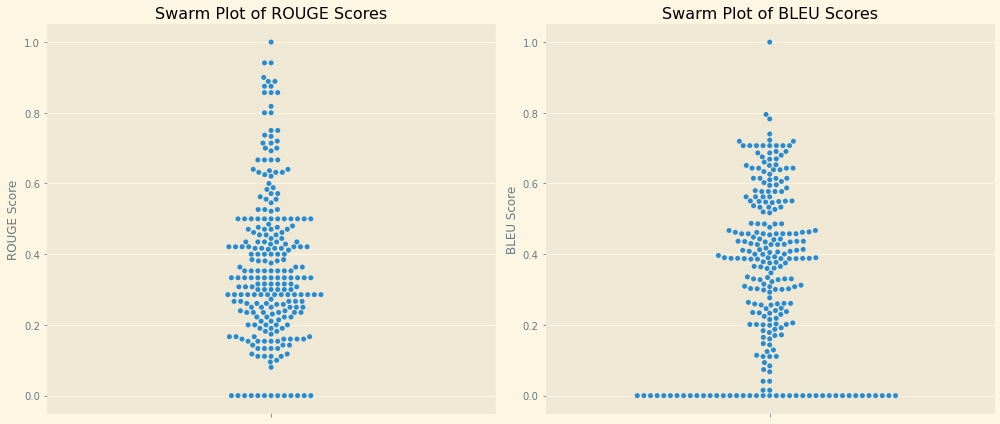

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.swarmplot(data=df, y='ROUGE Score')
plt.title('Swarm Plot of ROUGE Scores')

plt.subplot(1, 2, 2)
sns.swarmplot(data=df, y='BLEU Score')
plt.title('Swarm Plot of BLEU Scores')

plt.tight_layout()
plt.show()

The image shows two side-by-side swarm plots: one for ROUGE scores and one for BLEU scores. Swarm plots are useful for visualizing the distribution of data points while avoiding overlap, which provides a clear view of the density and spread of the data.

***1. Swarm Plot of ROUGE Scores (Left Plot)***
- **Y-Axis (ROUGE Score):**
  - Represents the ROUGE scores, specifically ROUGE-L F1 scores, which measure the overlap between the predicted titles and the true titles, focusing on the longest common subsequence.
  - The scores range from 0.0 to 1.0, with higher scores indicating better overlap between the predicted and true titles.

- **Interpretation:**
  - **Clustered Points:**
    - The points are concentrated around certain values, particularly around 0.3 to 0.6, indicating that most of the predictions have ROUGE scores in this range. This suggests that many of the model’s predictions capture some aspects of the true titles but with varying degrees of accuracy.
  - **Low Scores:**
    - There is a significant number of points at or near 0.0, which indicates that for these predictions, the model’s output has very little to no overlap with the true titles.
  - **High Scores:**
    - A few points are scattered towards the top of the plot, near 1.0, indicating that some predictions are nearly perfect matches to the true titles. These are outliers in terms of high performance.

***2. Swarm Plot of BLEU Scores (Right Plot)***
- **Y-Axis (BLEU Score):**
  - Represents the BLEU scores, which measure the n-gram overlap between the predicted titles and the true titles. BLEU is particularly sensitive to exact matches of sequences (n-grams) between the two texts.
  - The scores range from 0.0 to 1.0, with higher scores indicating better n-gram precision.

- **Interpretation:**
  - **Clustered Points:**
    - Similar to the ROUGE plot, the BLEU scores are also clustered around certain values, particularly around 0.3 to 0.6. This indicates that many of the predictions have a moderate level of n-gram overlap with the true titles.
  - **Low Scores:**
    - There is a substantial cluster of points at 0.0, which suggests that there are many cases where the predicted titles share very few or no n-grams with the true titles. These could be considered cases where the model struggled the most.
  - **High Scores:**
    - A few points near the top of the plot, around 1.0, indicate that some predictions have nearly perfect n-gram matches with the true titles, although these cases are rare.

***General Observations***
- **Distribution:**
  - Both swarm plots show that the majority of the predictions fall within a mid-range of scores (around 0.3 to 0.6), indicating that the model is often partially correct but rarely perfect.
  - The presence of numerous low-score predictions in both plots (especially at 0.0) suggests that there are several cases where the model’s predictions are far off from the true titles, either due to lack of relevance or completely missing key content.

- **High-Performance Outliers:**
  - The few high-score outliers (points near 1.0) in both plots indicate that the model occasionally performs exceptionally well, producing predictions that are either exact matches or very close to the true titles.

***Next Steps***
- **Analyze Low-Score Predictions:**
  - Focus on analyzing the instances with low ROUGE and BLEU scores to understand where the model is failing. Are there common characteristics among the abstracts or titles that lead to these poor predictions?
  
- **Improve Model Robustness:**
  - Consider strategies to improve the model’s ability to consistently generate relevant titles, such as fine-tuning with more data, experimenting with different model architectures, or using data augmentation techniques to handle difficult cases better.

- **Balance Performance:**
  - Aim to increase the number of predictions that fall into higher score ranges by refining the model’s ability to understand both content structure (ROUGE) and precise phrasing (BLEU).

These swarm plots provide a detailed visualization of how your model's predictions are distributed across the evaluation metrics, giving you clear insights into where the model excels and where it might need improvement.

## Pairplot

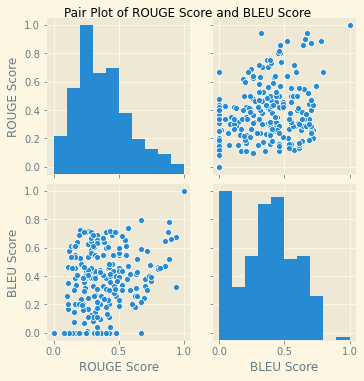

In [ ]:
sns.pairplot(df[['ROUGE Score', 'BLEU Score']])
plt.suptitle('Pair Plot of ROUGE Score and BLEU Score', y=1.02)
plt.show()

The plot is a **pair plot**, also known as a scatterplot matrix. Pair plots are used to visualize the relationships between multiple variables in a dataset, and they typically include histograms or density plots on the diagonal to show the distribution of each variable.

This pair plot shows the relationship between ROUGE scores and BLEU scores. There are four subplots arranged in a grid:

***1. Top Left (ROUGE Score Histogram)***
- **X-Axis**: ROUGE Score
- **Y-Axis**: Frequency
- **Interpretation**:
  - This is a histogram showing the distribution of ROUGE scores.
  - Most ROUGE scores are concentrated between 0.3 and 0.6, with a few scores closer to 0 and some higher scores closer to 1. This indicates that while most predictions have a moderate overlap with the true titles, a few have very high or very low overlap.

***2. Top Right (Scatter Plot: ROUGE Score vs BLEU Score)***
- **X-Axis**: BLEU Score
- **Y-Axis**: ROUGE Score
- **Interpretation**:
  - This scatter plot shows the relationship between ROUGE scores and BLEU scores.
  - There’s no strong linear correlation, but generally, higher ROUGE scores tend to correspond to higher BLEU scores. This suggests that as the model gets better at capturing overall structure (ROUGE), it also tends to do better with n-gram precision (BLEU), but with considerable variability.

***3. Bottom Left (Scatter Plot: ROUGE Score vs BLEU Score)***
- **X-Axis**: ROUGE Score
- **Y-Axis**: BLEU Score
- **Interpretation**:
  - This is essentially the same plot as the top right one, but with the axes flipped.
  - It confirms the observations from the top right scatter plot: there's some degree of correlation between the two metrics, but it's not perfectly linear. The scatter shows that while many points cluster in the middle, there are also many cases with either high ROUGE but lower BLEU, or vice versa.

***4. Bottom Right (BLEU Score Histogram)***
- **X-Axis**: BLEU Score
- **Y-Axis**: Frequency
- **Interpretation**:
  - This histogram shows the distribution of BLEU scores.
  - The BLEU scores are more widely spread, with some clustering near 0 (indicating poor n-gram overlap) and a significant number around 0.3 to 0.6. There are fewer very high BLEU scores, indicating that perfect or near-perfect n-gram matches are rare.

***General Observations***
- **Correlation Between ROUGE and BLEU Scores**:
  - The scatter plots suggest that while there is some positive relationship between ROUGE and BLEU scores, it is not very strong. Improvements in one metric don’t necessarily mean improvements in the other, though there is a general trend where higher scores in one metric correspond to higher scores in the other.
  
- **Distribution**:
  - The histograms show that most predictions fall in the mid-range for both metrics, indicating moderate performance, with fewer predictions achieving very high or very low scores.

***Potential Next Steps***
- **Improving Low-Score Predictions**: Investigate cases where either ROUGE or BLEU scores are low to understand why the model fails in these cases. These might represent specific types of titles or abstracts that the model struggles with.
- **Model Fine-Tuning**: To improve both metrics, consider adjusting the model or data preprocessing techniques to better capture both the overall structure and specific wording of the true titles.

This pair plot provides a comprehensive overview of how ROUGE and BLEU scores relate to each other and their individual distributions, offering insights that can guide further model refinement. Let me know if you need more details or additional analysis!

## Violin Plots

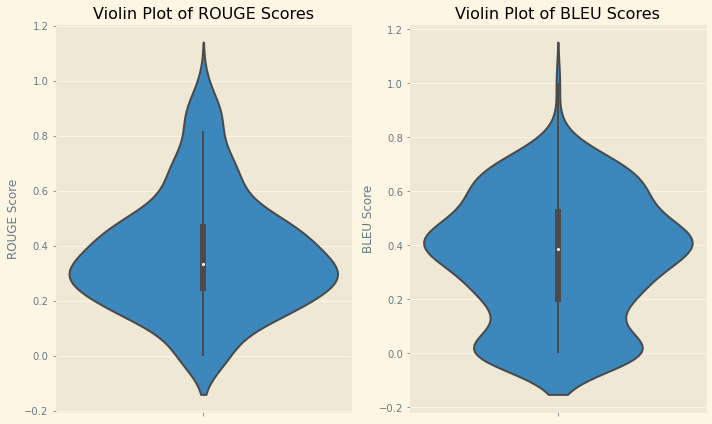

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.violinplot(data=df, y='ROUGE Score')
plt.title('Violin Plot of ROUGE Scores')

plt.subplot(1, 2, 2)
sns.violinplot(data=df, y='BLEU Score')
plt.title('Violin Plot of BLEU Scores')

plt.tight_layout()
plt.show()

The image shows two side-by-side **violin plots**: one for ROUGE scores and one for BLEU scores. Violin plots are a combination of a box plot and a kernel density plot, and they provide insights into the distribution of the data, as well as the density of different values.

***1. Violin Plot of ROUGE Scores (Left Plot)***
- **Y-Axis (ROUGE Score):**
  - Represents the ROUGE scores, specifically ROUGE-L F1 scores, which measure the overlap between the predicted titles and the true titles, focusing on the longest common subsequence.
  - The scores range from 0.0 to 1.0, with higher scores indicating better overlap.

- **Interpretation:**
  - **Shape of the Violin:**
    - The violin plot shows a symmetric shape with wider sections indicating where data points are more densely concentrated.
    - The widest section appears around 0.3 to 0.5, suggesting that most ROUGE scores fall within this range. This indicates that many of the model's predictions have a moderate overlap with the true titles.
  - **Box Plot Elements:**
    - Inside the violin plot, you can see a box plot that shows the interquartile range (IQR), median (the white dot), and the whiskers.
    - The median is around 0.45, indicating that half of the ROUGE scores are below this value and half are above.
  - **Density Peaks:**
    - There are peaks at both ends, indicating the presence of some very low scores near 0 and some high scores closer to 1, though these are less common.

***2. Violin Plot of BLEU Scores (Right Plot)***
- **Y-Axis (BLEU Score):**
  - Represents the BLEU scores, which measure the n-gram overlap between the predicted titles and the true titles. BLEU scores are often used to evaluate how well the predicted text matches the true text on a word or phrase level.
  - The scores also range from 0.0 to 1.0, with higher scores indicating better n-gram precision.

- **Interpretation:**
  - **Shape of the Violin:**
    - The BLEU score violin plot also shows a wider section around 0.3 to 0.5, indicating that many predictions have moderate n-gram overlap with the true titles.
    - The distribution is somewhat similar to the ROUGE plot, with the widest section and most data points concentrated in the mid-range.
  - **Box Plot Elements:**
    - The box plot within the violin shows the interquartile range (IQR), median, and whiskers.
    - The median is similar to that in the ROUGE plot, around 0.4 to 0.45.
  - **Density Peaks:**
    - Like the ROUGE plot, there are peaks at low scores near 0 and high scores closer to 1, but the middle range is more densely populated.

***General Observations***
- **Central Tendency:** Both ROUGE and BLEU scores have medians around 0.4 to 0.45, indicating that the model typically performs moderately well, but there is room for improvement.
- **Density Distribution:**
  - The density plots indicate that the most common scores for both metrics are in the mid-range (0.3 to 0.5), with fewer instances of very high or very low scores.
  - The presence of some higher scores closer to 1.0 suggests that the model occasionally produces highly accurate predictions, although these are less frequent.
- **Spread:**
  - The plots show that there is a reasonable spread of scores, with some data points reaching close to 0 (indicating poor performance) and others close to 1 (indicating excellent performance).

***Potential Next Steps***
- **Focus on Improving Lower Scores:** Given that there are some predictions with very low ROUGE and BLEU scores, it might be useful to analyze these cases to understand why the model struggles with them and to develop strategies for improvement.
- **Leverage High-Performance Predictions:** On the other hand, analyzing cases with high scores can provide insights into what the model is doing well, which can be reinforced and generalized to improve overall performance.

These violin plots provide a detailed view of the distribution and density of your model’s performance metrics, helping you identify areas of strength and weakness. Let me know if you need further analysis or assistance!

# Conclusion

This project aimed to automate the generation of titles from research paper abstracts using advanced natural language processing techniques. By employing a Seq2Seq model with a Transformer-based architecture, we sought to evaluate the model's effectiveness in producing titles that are both relevant and accurate.

***Model Performance***
- **Average ROUGE Score:** The model achieved an average ROUGE-L score of **0.369**, indicating a moderate level of overlap between the predicted titles and the true titles. This suggests that the model is somewhat successful in capturing the key components and structure of the true titles but still misses out on certain aspects that could improve the relevance and completeness of the generated titles.
  
- **Average BLEU Score:** With an average BLEU score of **0.354**, the model demonstrates its ability to produce phrases and sequences of words that partially match those in the true titles. This score reflects a moderate precision in the generated titles but also highlights the challenges in replicating the exact wording and n-gram sequences of the true titles.

- **Exact Match Accuracy:** The exact match accuracy was found to be **0.4%**. This low accuracy indicates that only a very small fraction of the generated titles were exact matches to the true titles. While the model does generate titles that share some similarities with the true titles (as evidenced by the ROUGE and BLEU scores), achieving an exact match remains a significant challenge due to the variability and flexibility in how titles can be phrased.

***Implications***
- The results indicate that while the model can generate titles that are reasonably relevant to the abstracts, there is substantial room for improvement, particularly in achieving higher accuracy and more precise text generation. The moderate ROUGE and BLEU scores suggest that the model often captures important elements of the titles, but refining these predictions to be more accurate and closer to the true titles will require further work.

- The very low exact match accuracy highlights the inherent difficulty in title generation tasks, where numerous valid titles might exist for a single abstract, making it challenging for the model to consistently produce exact matches.

***Future Work***
- **Error Analysis:** A deeper error analysis is necessary to identify common failure modes, such as specific types of abstracts that consistently result in poor title generation. Understanding these patterns can guide further improvements.
  
- **Model Fine-Tuning:** Future iterations of the model could benefit from additional fine-tuning, perhaps with domain-specific data or incorporating techniques like beam search to improve the quality of generated titles.

- **Exploration of Advanced Architectures:** Experimenting with more sophisticated models or hybrid approaches that combine rule-based and machine learning techniques could help improve both the relevance and precision of the generated titles.

In conclusion, this project has successfully demonstrated the potential of using NLP models for automated title generation, providing a foundation for further research and development. With additional refinement, such systems could significantly enhance the efficiency of the academic publication process and improve the discoverability of research papers.